In [ ]:
# Import our dependencies
import psycopg2 as pg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

In [35]:
# Postgres Connection
#engine = pg.connect("dbname='Capstone_Project' user='postgres' host='127.0.0.1' port='5432' password=''")
#df = pd.read_sql("select * from usaf_table", con=engine)

In [36]:
# Temporary CSV connection to work with model
 
usaf_df = pd.read_csv("https://raw.githubusercontent.com/CPotts82/Project_Practice/main/Vietnam_USAF_Losses_Cleaned_Data.csv")
usaf_df.head()

,Crash_Date,Crash_Time,Aircraft_Type,Aircraft_SN,Base,Wing,Squadron,Call_Sign,Operations_Code,Mission_Type,...,Pilot_Egress,Pilot_Status,Pilot_Condition,Pilot_Recovered,Co_Pilot_Nav_Rank,Co_Pilot_Nav,Co_Pilot_Nav_Egress,Co_Pilot_Nav_Status,Co_Pilot_Nav_Condition,Co_Pilot_Recovered
0,1962-02-02,_,C-123B,564370,TSN,464TCW,_,_,IC,NaN,...,Crash,KIA,_,_,Capt,Larsen R. D.,Crash,KIA,_,_
1,1962-02-11,_,SC-47A,4315732,BHA,_,4400CCTS,_,IC,NaN,...,Crash,KIA,_,_,Capt,Hartson S. G.,Crash,KIA,_,_
2,1962-08-28,_,T-28B,538376,_,_,_,_,IC,NaN,...,_,KIA,_,_,Capt,_,_,_,_,_
3,1962-10-15,_,U-10,625909,_,_,_,_,IC,NaN,...,Crash,KIA,_,_,Capt,Foxx R. L.,Crash,KIA,_,_
4,1962-10-16,_,T-28B,538365,_,_,_,_,IC,NaN,...,Ejection,Recovered,Minor injuries,_,Capt,_,_,_,_,_


In [37]:
# Create dataframe with variables for model

usaf_df_model = usaf_df.filter(['Crash_Date','Aircraft_Type','Base', 'Defense_Type', 'Mission_Phase', 'Pilot_Status'], axis=1)

usaf_df_model.head()

,Crash_Date,Aircraft_Type,Base,Defense_Type,Mission_Phase,Pilot_Status
0,1962-02-02,C-123B,TSN,_,Enroute,KIA
1,1962-02-11,SC-47A,BHA,Gunfire (combat associated),_,KIA
2,1962-08-28,T-28B,_,Gunfire,_,KIA
3,1962-10-15,U-10,_,Gunfire,_,KIA
4,1962-10-16,T-28B,_,Gunfire,_,Recovered


In [38]:
# Remove rows that have string value "_".

usaf_df_modelv3 = usaf_df_model[usaf_df_model["Aircraft_Type"].str.contains("_")==False]

usaf_df_modelv4 = usaf_df_modelv3[usaf_df_modelv3["Base"].str.contains("_")==False]

usaf_df_modelv5 = usaf_df_modelv4[usaf_df_modelv4["Defense_Type"].str.contains("_")==False]

usaf_df_modelv6 = usaf_df_modelv5[usaf_df_modelv5["Mission_Phase"].str.contains("_")==False]

usaf_cleaned_nulls = usaf_df_modelv6[usaf_df_modelv6["Pilot_Status"].str.contains("_")==False]

usaf_cleaned_nulls.head(20)

,Crash_Date,Aircraft_Type,Base,Defense_Type,Mission_Phase,Pilot_Status
21,1964-03-24,T-28,BHA,Gunfire,At target,KIA
24,1964-06-26,T-28D,BHA,Gunfire,At target,Recovered
25,1964-08-06,B-57B,CLK,Gunfire,Enroute,KIA
28,1964-08-29,A-1E,BHA,30cal AAA,Enroute,KIA
31,1964-09-26,A-1E,BHA,Gunfire,At target,Recovered
32,1964-10-02,A-1E,BHA,Gunfire,At target,KIA
34,1964-10-26,A-1E,TSN,Gunfire,At target,KIA
36,1964-11-19,T-28D,UDN,30cal AAA,Enroute,KIA
38,1964-12-01,A-1E,BHA,Gunfire,Enroute,Recovered
46,1965-03-02,F-105D,KRT,Heavy 37mm AAA,At target,Recovered


In [39]:
# Determine the number of unique values in each column.
usaf_cleaned_nulls.nunique()

Crash_Date       836
Aircraft_Type     64
Base              33
Defense_Type     214
Mission_Phase      6
Pilot_Status      13
dtype: int64

In [40]:
# Look at Aircraft_Type value counts for binning
aircraft_counts = usaf_cleaned_nulls.Aircraft_Type.value_counts()
aircraft_counts

F-105D    276
F-4C      127
F-4D      124
F-100D    110
A-1E       76
         ... 
A-1         1
F-102       1
C-123K      1
A-1H/J      1
RC-47       1
Name: Aircraft_Type, Length: 64, dtype: int64

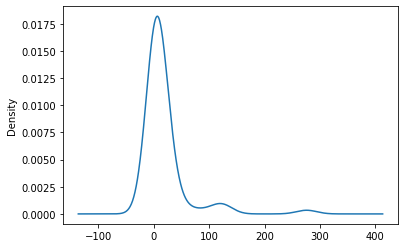

In [41]:
# Visualize the value counts of Aircraft_Type
aircraft_counts.plot.density()

In [42]:
# Determine which values to replace if counts are less than ...?
replace_aircraft = list(aircraft_counts[aircraft_counts < 20].index)

# Replace in dataframe
for aircraft in replace_aircraft:
    usaf_cleaned_nulls.Aircraft_Type = usaf_cleaned_nulls.Aircraft_Type.replace(aircraft,"Other")
    
# Check to make sure binning was successful
usaf_cleaned_nulls.Aircraft_Type.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


F-105D    276
Other     265
F-4C      127
F-4D      124
F-100D    110
A-1E       76
RF-4C      40
A-1H       39
F-4E       39
F-100      23
F-100F     23
F-105F     23
O-2        20
Name: Aircraft_Type, dtype: int64

In [43]:
# Look at Base value counts for binning
base_counts = usaf_cleaned_nulls.Base.value_counts()
base_counts

KRT    176
TKL    164
DNG    135
UBN    113
UDN    110
BHA     94
NKP     83
PHR     59
CRB     49
PHC     44
PLK     38
TSN     37
THA     26
NTR     24
UTP      9
AND      4
KSN      3
CLK      2
PBI      1
STR      1
DBG      1
BMT      1
DUC      1
CCH      1
PCV      1
BTY      1
QTR      1
V35      1
CLI      1
BNH      1
SBE      1
VTA      1
DTG      1
Name: Base, dtype: int64

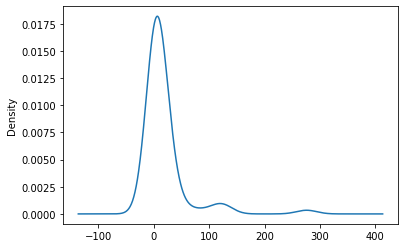

In [44]:
# Visualize the value counts of Base
aircraft_counts.plot.density()

In [45]:
# Determine which values to replace if counts are less than ...?
replace_base = list(base_counts[base_counts < 40].index)

# Replace in dataframe
for base in replace_base:
    usaf_cleaned_nulls.Base = usaf_cleaned_nulls.Base.replace(base,"Other")
    
# Check to make sure binning was successful
usaf_cleaned_nulls.Base.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


KRT      176
TKL      164
Other    158
DNG      135
UBN      113
UDN      110
BHA       94
NKP       83
PHR       59
CRB       49
PHC       44
Name: Base, dtype: int64

In [46]:
# Look at Defense_Type value counts for binning
defense_counts = usaf_cleaned_nulls.Defense_Type.value_counts()
defense_counts

Gunfire                                             262
37mm AAA                                             77
SAM                                                  72
Small arms                                           47
Automatic weapons                                    45
                                                   ... 
Heavy aimed AAA                                       1
Small arms (poss.)                                    1
Heavy barrage automatic weapons (prob. 57mm AAA)      1
Light aimed small arms (unknown type)                 1
Mid-air collission with OV-10                         1
Name: Defense_Type, Length: 214, dtype: int64

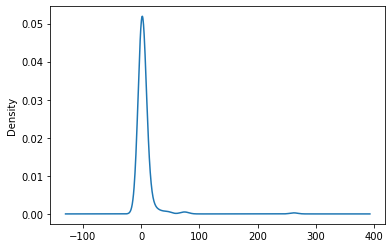

In [47]:
# Visualize the value counts of Defense_Type
defense_counts.plot.density()

In [48]:
# Determine which values to replace if counts are less than ...?
replace_defense = list(defense_counts[defense_counts < 25].index)

# Replace in dataframe
for defense in replace_defense:
    usaf_cleaned_nulls.Defense_Type = usaf_cleaned_nulls.Defense_Type.replace(defense,"Other")
    
# Check to make sure binning was successful
usaf_cleaned_nulls.Defense_Type.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Other                                590
Gunfire                              262
37mm AAA                              77
SAM                                   72
Small arms                            47
Automatic weapons                     45
37/57mm AAA                           34
Gunfire (poss. combat associated)     32
(Combat associated)                   26
Name: Defense_Type, dtype: int64

In [49]:
# Look at Pilot_Status value counts for categories
pilot_counts = usaf_cleaned_nulls.Pilot_Status.value_counts()
pilot_counts

Recovered                  511
KIA                        347
POW (returned)             156
MIA                        151
POW (died)                   5
POW                          4
KIA (chute failure)          3
Recoverd                     2
u                            2
KIA (chute failed)           1
Recovered DaNang             1
POW (died in captivity)      1
recovered                    1
Name: Pilot_Status, dtype: int64

In [52]:
# Clean the Target variable - Create binomial

status = {'Recovered': 1, 'KIA': 0,'POW (returned)': 1,'MIA': 0,'POW (died)': 0,'POW': 1,'KIA (chute failure)': 0,'Recoverd': 1, 'u': 0, 
    'KIA (chute failed)': 0, 'Recovered DaNang': 1, 'POW (died in captivity)':0, 'Recovered (chute fail)': 1,'recovered': 1,'KIA,body MIA,PJ abandnd': 1, 'POW (died in captivity)': 0}

usaf_df = usaf_cleaned_nulls.replace({"Pilot_Status": status})
usaf_df.head(20)

,Crash_Date,Aircraft_Type,Base,Defense_Type,Mission_Phase,Pilot_Status
21,1964-03-24,Other,BHA,Gunfire,At target,0
24,1964-06-26,Other,BHA,Gunfire,At target,1
25,1964-08-06,Other,Other,Gunfire,Enroute,0
28,1964-08-29,A-1E,BHA,Other,Enroute,0
31,1964-09-26,A-1E,BHA,Gunfire,At target,1
32,1964-10-02,A-1E,BHA,Gunfire,At target,0
34,1964-10-26,A-1E,Other,Gunfire,At target,0
36,1964-11-19,Other,UDN,Other,Enroute,0
38,1964-12-01,A-1E,BHA,Gunfire,Enroute,1
46,1965-03-02,F-105D,KRT,Other,At target,1


In [57]:
# Generate our categorical variable lists
usaf_cat = usaf_df.dtypes[usaf_df.dtypes == "object"].index.tolist()
usaf_cat

['Crash_Date', 'Aircraft_Type', 'Base', 'Defense_Type', 'Mission_Phase']

In [58]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(usaf_df[usaf_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(usaf_cat)
encode_df.head()

,Crash_Date_1872-02-17,Crash_Date_1872-03-06,Crash_Date_1872-03-18,Crash_Date_1872-03-23,Crash_Date_1872-03-30,Crash_Date_1872-04-02,Crash_Date_1872-04-03,Crash_Date_1872-04-07,Crash_Date_1872-04-09,Crash_Date_1872-04-15,...,Defense_Type_Gunfire (poss. combat associated),Defense_Type_Other,Defense_Type_SAM,Defense_Type_Small arms,Mission_Phase_At target,Mission_Phase_Enroute,Mission_Phase_On recce,Mission_Phase_On station,Mission_Phase_Return,Mission_Phase_Transit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# Merge one-hot encoded features and drop the originals
usaf_df = usaf_df.merge(encode_df, left_index=True, right_index=True)
usaf_df = usaf_df.drop(usaf_cat, 1)
usaf_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Pilot_Status,Crash_Date_1872-02-17,Crash_Date_1872-03-06,Crash_Date_1872-03-18,Crash_Date_1872-03-23,Crash_Date_1872-03-30,Crash_Date_1872-04-02,Crash_Date_1872-04-03,Crash_Date_1872-04-07,Crash_Date_1872-04-09,...,Defense_Type_Gunfire (poss. combat associated),Defense_Type_Other,Defense_Type_SAM,Defense_Type_Small arms,Mission_Phase_At target,Mission_Phase_Enroute,Mission_Phase_On recce,Mission_Phase_On station,Mission_Phase_Return,Mission_Phase_Transit
21,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
24,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Split our preprocessed data into our features and target arrays
y = usaf_df["Pilot_Status"].values 
X = usaf_df.drop(["Pilot_Status"], 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [62]:
len(X_train[0])

875

In [69]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 450
hidden_nodes_layer2 = 200
hidden_nodes_layer3 = 100

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='tanh'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 450)               394200    
                                                                 
 dense_5 (Dense)             (None, 200)               90200     
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 504,601
Trainable params: 504,601
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [71]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [72]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period = 5
    )

In [73]:
# Train the model
fit_model = nn.fit(X_train, y_train, epochs=50, callbacks=[cp_callback])

Epoch 1/50
23/23 [==============================] - 1s 7ms/step - loss: 0.6879 - accuracy: 0.5708
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6315 - accuracy: 0.6139
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.4922 - accuracy: 0.7792
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.2156 - accuracy: 0.9361
Epoch 5/50
16/23 [===================>..........] - ETA: 0s - loss: 0.0708 - accuracy: 0.9766
Epoch 5: saving model to checkpoints/weights.05.hdf5
23/23 [==============================] - 0s 8ms/step - loss: 0.0812 - accuracy: 0.9694
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0656 - accuracy: 0.9847
Epoch 7/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9847
Epoch 8/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0518 - accuracy: 0.9861
Epoch 9/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0367 -

In [74]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 5.9365 - accuracy: 0.4979 - 177ms/epoch - 22ms/step
Loss: 5.9364800453186035, Accuracy: 0.4979253113269806
